# Import Libraries

In [83]:
import re
import os
import seaborn as sns
import pandas as pd
import numpy as np

import plotly.express as px
import plotly.graph_objects as go
from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.mplot3d import Axes3D

from scipy.stats.mstats import winsorize
from scipy.interpolate import griddata

from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold, train_test_split, GridSearchCV, learning_curve
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.feature_selection import RFECV, SelectKBest, f_regression

import xgboost

import pickle as pkl

In [3]:
import warnings
warnings.filterwarnings('ignore')

# Functions

In [9]:
## Recursive Feature Elimination with Cross-Validation
def rfecv(estimator, X, y, step, cv):
    rfecv = RFECV(estimator=estimator, 
                  step=step, 
                  cv=KFold(cv, 
                           shuffle=True, 
                           random_state=42),
                  scoring='neg_mean_squared_error')
    rfecv.fit(X, y)
    return rfecv

## Plotting % of Correct Classification
def plot_pcc(rfecv, title):
    
    plt.figure(figsize=(10, 9))
    plt.title(title, 
              fontsize=18, 
              fontweight='bold', 
              pad=20)
    plt.xlabel('Number of features selected', 
               fontsize=14, 
               labelpad=20)
    plt.ylabel('% Correct Classification', 
               fontsize=14, 
               labelpad=20)
    plt.plot(range(1, len(rfecv.cv_results_['mean_test_score']) + 1), 
             rfecv.cv_results_['mean_test_score'], 
             color='#303F9F', 
             linewidth=3)
    
    plt.show()

## Plotting feature importances
def feature_importance(rfecv, X, title): 
        
    df = pd.DataFrame()
    
    df['column'] = X.columns
    df['importance'] = rfecv.estimator_.feature_importances_
    
    df.sort_values(by='importance', 
                   ascending=False, 
                   inplace=True, 
                   ignore_index=True)
    
    sns.set(rc = {'figure.figsize':(8,10)})
    ax = sns.barplot(y='column', 
                     x='importance',
                     data=df,
                     palette='viridis')
    
    ax.set_title(title, 
                 fontsize=18)

## Predicting validation data
def pred_val(df, columns, sc, model):

    scaled_df = sc.transform(df)
    
    scaled_df = pd.DataFrame(scaled_df, 
                             columns=df.columns)
    
    scaled_df = scaled_df[columns]

    # pca_df = pca.transform(scaled_df)

    y_pred = model.predict(scaled_df)

    return y_pred

## Evaluate the final model
def eval_model(y, y_pred, title):
    
    mse = mean_squared_error(y, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y, y_pred)
    r_squared = r2_score(y, y_pred)

    print(f'{title}')
    print(f'Mean Squared Error: {np.round(mse, 2)}')
    print(f'Root Mean Squared Error: {np.round(rmse, 2)}')
    print(f'Mean Absolute Error: {np.round(mae, 2)}')
    print(f'R-squared Error: {np.round(r_squared, 2)}')

## Plotting Learning curves
def plot_learing_curve(model, X, y, cv, model_title):

    train_sizes = [50, 100, 200, 300, 380]

    train_sizes, train_scores, validation_scores = learning_curve(model, X, y, 
                                                                  train_sizes=train_sizes, 
                                                                  cv=cv, 
                                                                  scoring='neg_mean_absolute_error', 
                                                                  shuffle=True)

    train_scores_mean = -train_scores.mean(axis=1)
    validation_scores_mean = -validation_scores.mean(axis=1)

    #plt.style.use('seaborn')
    plt.figure(figsize=(7, 5))
    plt.plot(train_sizes, 
             train_scores_mean, 
             label = 'Training error')
    plt.plot(train_sizes, 
             validation_scores_mean, 
             label = 'Validation error')
    plt.ylabel('Mean MAE', 
               fontsize = 14)
    plt.xlabel('Training set size', 
               fontsize = 14)
    plt.title(f'Learning curves for a {model_title} model', 
              fontsize = 18, 
              y = 1.03)
    plt.legend()
    plt.ylim(0,40)

## Outlier handling
def handle_outl(df):

    cols = list(df.columns)
    
    for elem in cols:
        
        Q1 = df[elem].quantile(0.25)
        Q3 = df[elem].quantile(0.75)
        IQR = Q3 - Q1
        lwr_bnd = Q1 - (1.5 * IQR)
        upr_bnd = Q3 + (1.5 * IQR)

        quantiles = {
            87 : df[elem].quantile(0.87), 
            90 : df[elem].quantile(0.90),
            92.5 : df[elem].quantile(0.925),
            95 : df[elem].quantile(0.95),
            97.5 : df[elem].quantile(0.975),
            99 : df[elem].quantile(0.99)
        }
        
        min_diff = float('inf')
        nearest_key = None
        for key, val in quantiles.items():
        
            if val >= upr_bnd:
                diff = val - upr_bnd
                if diff < min_diff:
                    min_diff = diff
                    nearest_key = key
        
        if nearest_key is None:
            df[elem] = df[elem].apply(lambda x: upr_bnd if x > upr_bnd else x)
            continue
        
        nearest_key = (100 - nearest_key) / 100
        nearest_key = np.round(nearest_key, 3)
        df[elem] = winsorize(df[elem], limits=(0.05, nearest_key))

    return df

# Load Data

In [4]:
curr_dir = (os.getcwd()).replace('\\', '/')
data_path = (os.path.join(curr_dir, 'Data')).replace('\\', '/')

In [28]:
str_sed_data = pd.read_csv(data_path + '/Kodangal dataset/Kodangal_gcM.csv')

In [29]:
str_sed_data.head()

,gid,objectid,sampleno,longitude,latitude,sio2,al2o3,fe2o3,tio2,cao,...,u,pt,pd,toposheet,in_,f,te,tl,hg,cd
0,274643,276298,56G04/014/SS/18-19,77.25,17.00904,44.750,9.414,3.312,0.543,14.668,...,1.811020,0,0,56G04,0.052741,322.0,0.101815,0.293517,17.0,50.0
1,274657,276312,56G04/028/SS/18-19,77.25,17.02711,45.129,9.853,3.748,0.580,14.042,...,2.203597,0,0,56G04,0.048799,336.0,0.072979,0.300787,8.0,50.0
2,274671,276326,56G04/042/SS/18-19,77.25,17.04518,58.283,12.534,7.768,1.321,2.910,...,2.711943,0,0,56G04,0.126064,205.0,0.121959,0.481961,12.0,50.0
3,274685,276340,56G04/056/SS/18-19,77.25,17.06325,61.180,11.670,8.340,1.420,2.430,...,2.982200,0,0,56G04,0.084033,230.0,0.071592,0.427797,10.0,50.0
4,274699,276354,56G04/070/SS/18-19,77.25,17.08132,60.300,11.470,8.270,1.430,1.990,...,3.249200,0,0,56G04,0.083470,300.0,0.067475,0.447018,6.0,50.0


# Regression

# EDA

In [30]:
rem_elem = []
for col in str_sed_data.columns:
    if (str_sed_data[col] == 0).all():
        rem_elem.append(col)
print(f"Elements which don't contribute in the sediment composition: {rem_elem}")

Elements which don't contribute in the sediment composition: ['loi', 'pt', 'pd']


In [31]:
str_sed_data.drop(rem_elem, axis=1, inplace=True)

In [32]:
str_sed_data.head()

,gid,objectid,sampleno,longitude,latitude,sio2,al2o3,fe2o3,tio2,cao,...,ta,w,u,toposheet,in_,f,te,tl,hg,cd
0,274643,276298,56G04/014/SS/18-19,77.25,17.00904,44.750,9.414,3.312,0.543,14.668,...,0.862203,0.991997,1.811020,56G04,0.052741,322.0,0.101815,0.293517,17.0,50.0
1,274657,276312,56G04/028/SS/18-19,77.25,17.02711,45.129,9.853,3.748,0.580,14.042,...,0.958655,0.943758,2.203597,56G04,0.048799,336.0,0.072979,0.300787,8.0,50.0
2,274671,276326,56G04/042/SS/18-19,77.25,17.04518,58.283,12.534,7.768,1.321,2.910,...,1.428838,1.682294,2.711943,56G04,0.126064,205.0,0.121959,0.481961,12.0,50.0
3,274685,276340,56G04/056/SS/18-19,77.25,17.06325,61.180,11.670,8.340,1.420,2.430,...,1.542800,1.803219,2.982200,56G04,0.084033,230.0,0.071592,0.427797,10.0,50.0
4,274699,276354,56G04/070/SS/18-19,77.25,17.08132,60.300,11.470,8.270,1.430,1.990,...,1.467300,1.451395,3.249200,56G04,0.083470,300.0,0.067475,0.447018,6.0,50.0


In [33]:
str_elem = []

for col in list(str_sed_data.columns):
    if col not in ['gid', 
                   'objectid', 
                   'sampleno', 
                   'longitude', 
                   'latitude', 
                   'toposheet']:
        str_elem.append(col)

In [34]:
len(str_elem)

62

In [35]:
elem_df = str_sed_data[str_elem]
elem_df.head()

,sio2,al2o3,fe2o3,tio2,cao,mgo,mno,na2o,k2o,p2o5,...,hf,ta,w,u,in_,f,te,tl,hg,cd
0,44.750,9.414,3.312,0.543,14.668,1.573,0.073,0.152,1.258,0.129,...,5.746369,0.862203,0.991997,1.811020,0.052741,322.0,0.101815,0.293517,17.0,50.0
1,45.129,9.853,3.748,0.580,14.042,1.480,0.109,0.167,1.207,0.080,...,7.857656,0.958655,0.943758,2.203597,0.048799,336.0,0.072979,0.300787,8.0,50.0
2,58.283,12.534,7.768,1.321,2.910,1.912,0.192,0.050,0.800,0.061,...,8.728652,1.428838,1.682294,2.711943,0.126064,205.0,0.121959,0.481961,12.0,50.0
3,61.180,11.670,8.340,1.420,2.430,1.710,0.180,0.250,0.660,0.080,...,9.365000,1.542800,1.803219,2.982200,0.084033,230.0,0.071592,0.427797,10.0,50.0
4,60.300,11.470,8.270,1.430,1.990,1.610,0.170,0.230,0.580,0.060,...,10.693400,1.467300,1.451395,3.249200,0.083470,300.0,0.067475,0.447018,6.0,50.0


In [36]:
zero_count_features = (elem_df == 0).sum()
df = zero_count_features[zero_count_features > 300]
df

au     392
li     392
cs     486
as_    578
sb     578
bi     578
se     578
ag     392
mo     486
w      485
in_    588
f      588
te     588
tl     588
dtype: int64

Half the dataset has 0 values for above columns. Hence we drop all the 588 rows which have 0 values.

In [37]:
elem_df = elem_df.head(588)
elem_df.tail(5)

,sio2,al2o3,fe2o3,tio2,cao,mgo,mno,na2o,k2o,p2o5,...,hf,ta,w,u,in_,f,te,tl,hg,cd
583,40.35,14.12,18.56,5.72,0.99,0.92,0.24,0.29,0.31,0.24,...,9.293523,2.304848,0.862960,1.990782,0.187086,276.0,0.091641,0.237900,27.0,50.0
584,46.83,20.08,12.71,2.34,0.68,0.68,0.25,0.20,1.07,0.17,...,10.184300,1.610289,2.937731,3.614382,0.137180,270.0,0.093281,0.705034,31.0,50.0
585,46.42,20.28,13.18,2.42,0.57,0.64,0.27,0.16,1.04,0.17,...,12.118209,1.693362,2.722033,3.865095,0.149293,329.0,0.118909,0.763413,33.0,50.0
586,42.12,15.07,17.11,4.32,2.72,1.16,0.22,0.33,0.29,0.16,...,5.680000,0.760000,0.576405,0.930000,0.111583,185.0,0.077013,0.141977,10.0,50.0
587,45.52,9.98,11.58,2.62,8.89,2.24,0.21,0.37,0.34,0.17,...,4.920000,0.360000,0.250000,0.880000,0.089209,186.0,0.062873,0.126050,16.0,50.0


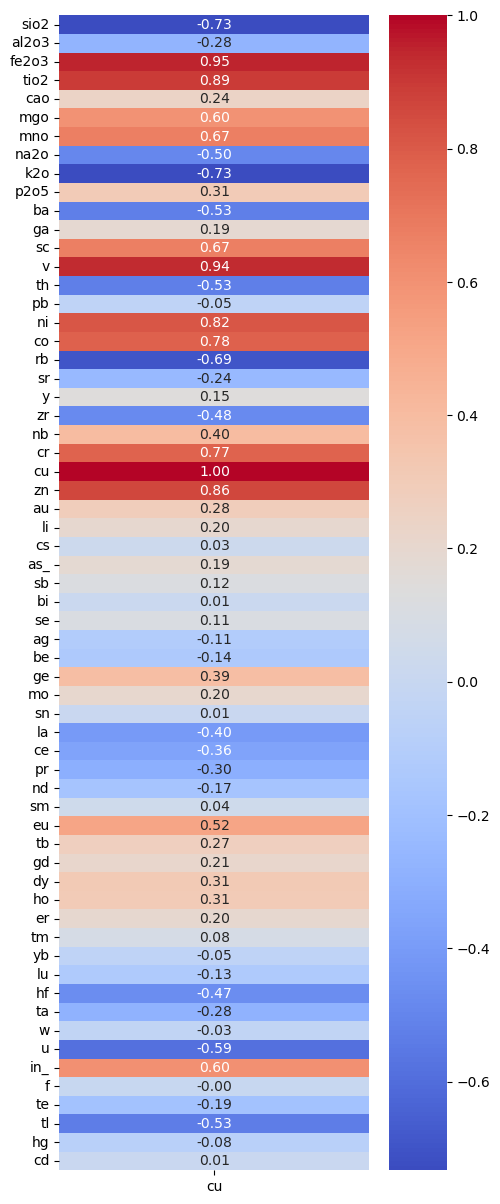

In [15]:
corr_df = elem_df.corr()
target_corr = corr_df[['cu']]

plt.figure(figsize=(5,15))
sns.heatmap(target_corr, 
            annot=True, 
            fmt=".2f", 
            cmap='coolwarm')
plt.show()

Highly (positive/negative) correlated features with 'cu' are - 'sio2', 'tio2', 'fe2o3', 'k2o', 'v', 'ni', 'co', 'cr', 'zn'.

### Histogram plots

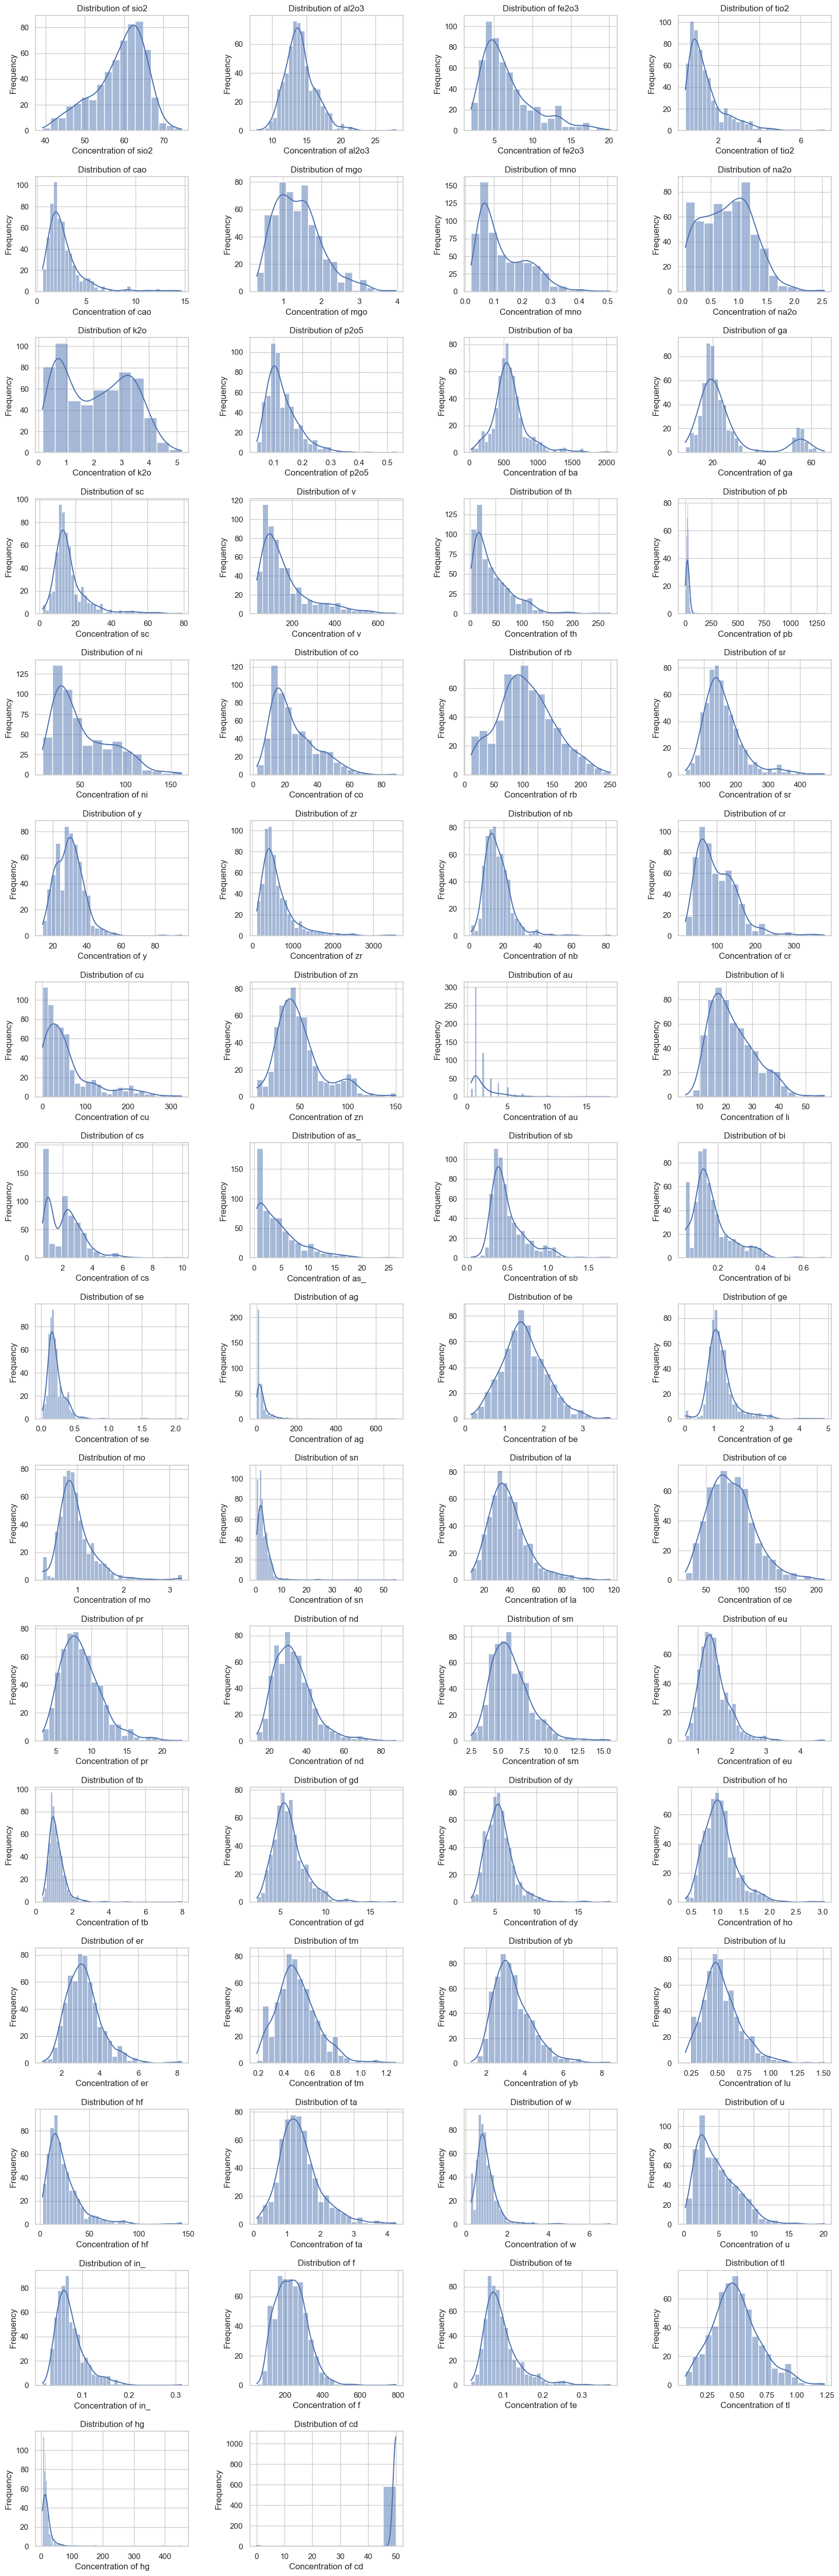

In [92]:
num_elem = len(str_elem)
num_cols = 4
num_rows = (num_elem + num_cols - 1)//num_cols 

sns.set(style='whitegrid')

fig, axes = plt.subplots(num_rows, 
                         num_cols, 
                         figsize=(num_cols*5, num_rows*4))

fig.subplots_adjust(hspace=0.4, 
                    wspace=0.4)

for i, elem in enumerate(str_elem):

    ax = axes[i // num_cols, i % num_cols]  # Determine the position in the grid
    sns.histplot(elem_df[elem], 
                 kde=True, 
                 ax=ax)
    ax.set_title(f'Distribution of {elem}')
    ax.set_xlabel(f'Concentration of {elem}')
    ax.set_ylabel('Frequency')

# If there are any empty subplots in the grid, hide them
for j in range(i + 1, num_rows * num_cols):
    axes[j // num_cols, j % num_cols].axis('off')

plt.show()

## Boxplots

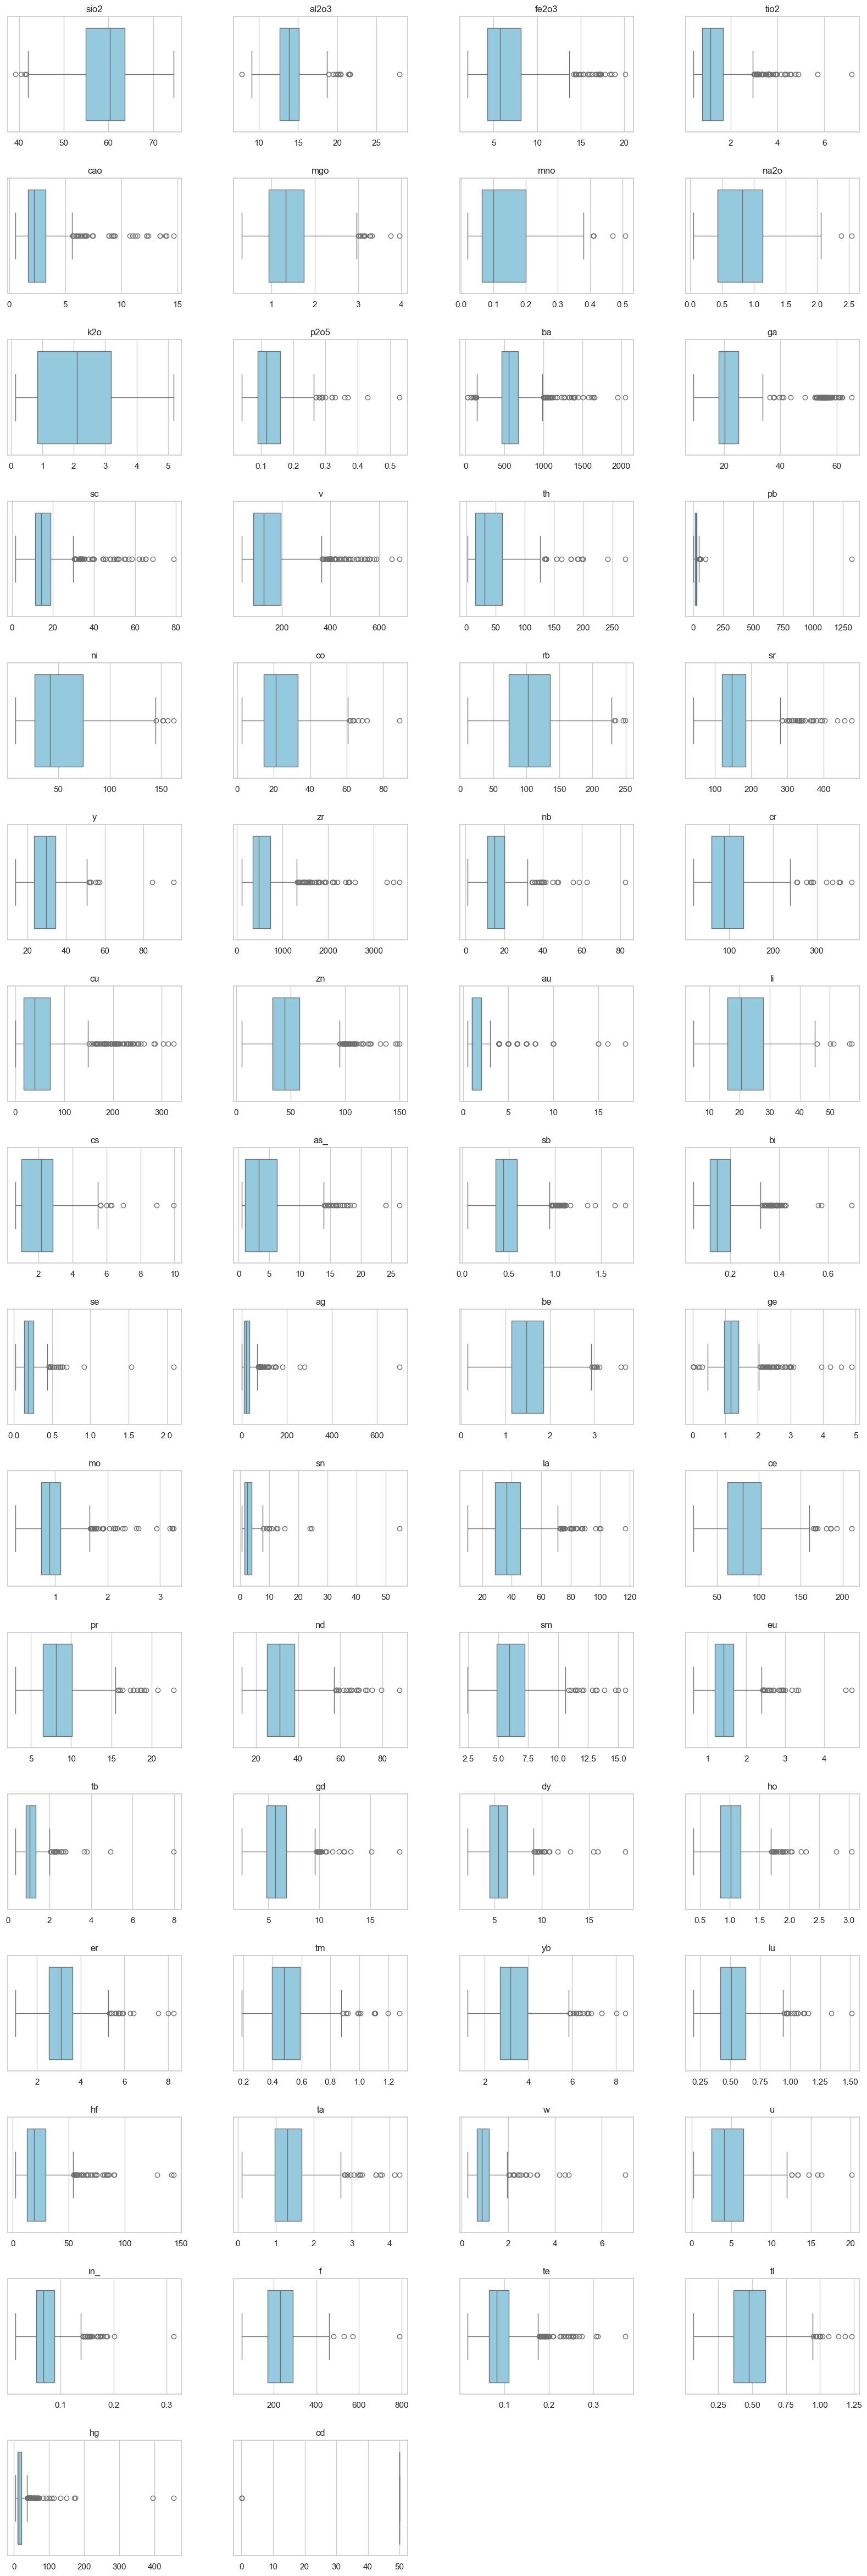

In [93]:
n_elem = len(str_elem)

fig, axes = plt.subplots(nrows=(n_elem+4-1)//4, 
                         ncols=4, 
                         figsize=(20, 4 * (n_elem//4)))

fig.subplots_adjust(hspace=0.4, wspace=0.3)  # Adjust spacing between plots

# Plot each element in its subplot
for i, (elem, ax) in enumerate(zip(str_elem, axes.flatten())):
    sns.boxplot(x=elem_df[str_elem][elem], 
                ax=ax, 
                color="skyblue")
    ax.set_title(elem)
    ax.set_xlabel('')  # Clear the x-labels if they clutter the plot

#If there are any leftover axes, turn them off
for j in range(i + 1, ((n_elem+4-1)//4) * 4):
    axes.flatten()[j].set_visible(False)

plt.show()

## Drop elements based on certain condition

- Elements having concentration values less than 1

In [38]:
drop_elem = ['mno', 'p2o5', 'sb', 'bi', 'se', 'ho', 'tm', 'lu', 'in_', 'te', 'tl']

In [39]:
elem_df.drop(drop_elem, axis=1, inplace=True)

- Elements having same almost same values at each sample

In [40]:
elem_df.drop(['cd'], axis=1, inplace=True)

## Handling outliers

In [42]:
elem_outl_df = handle_outl(elem_df)

### After handling outliers

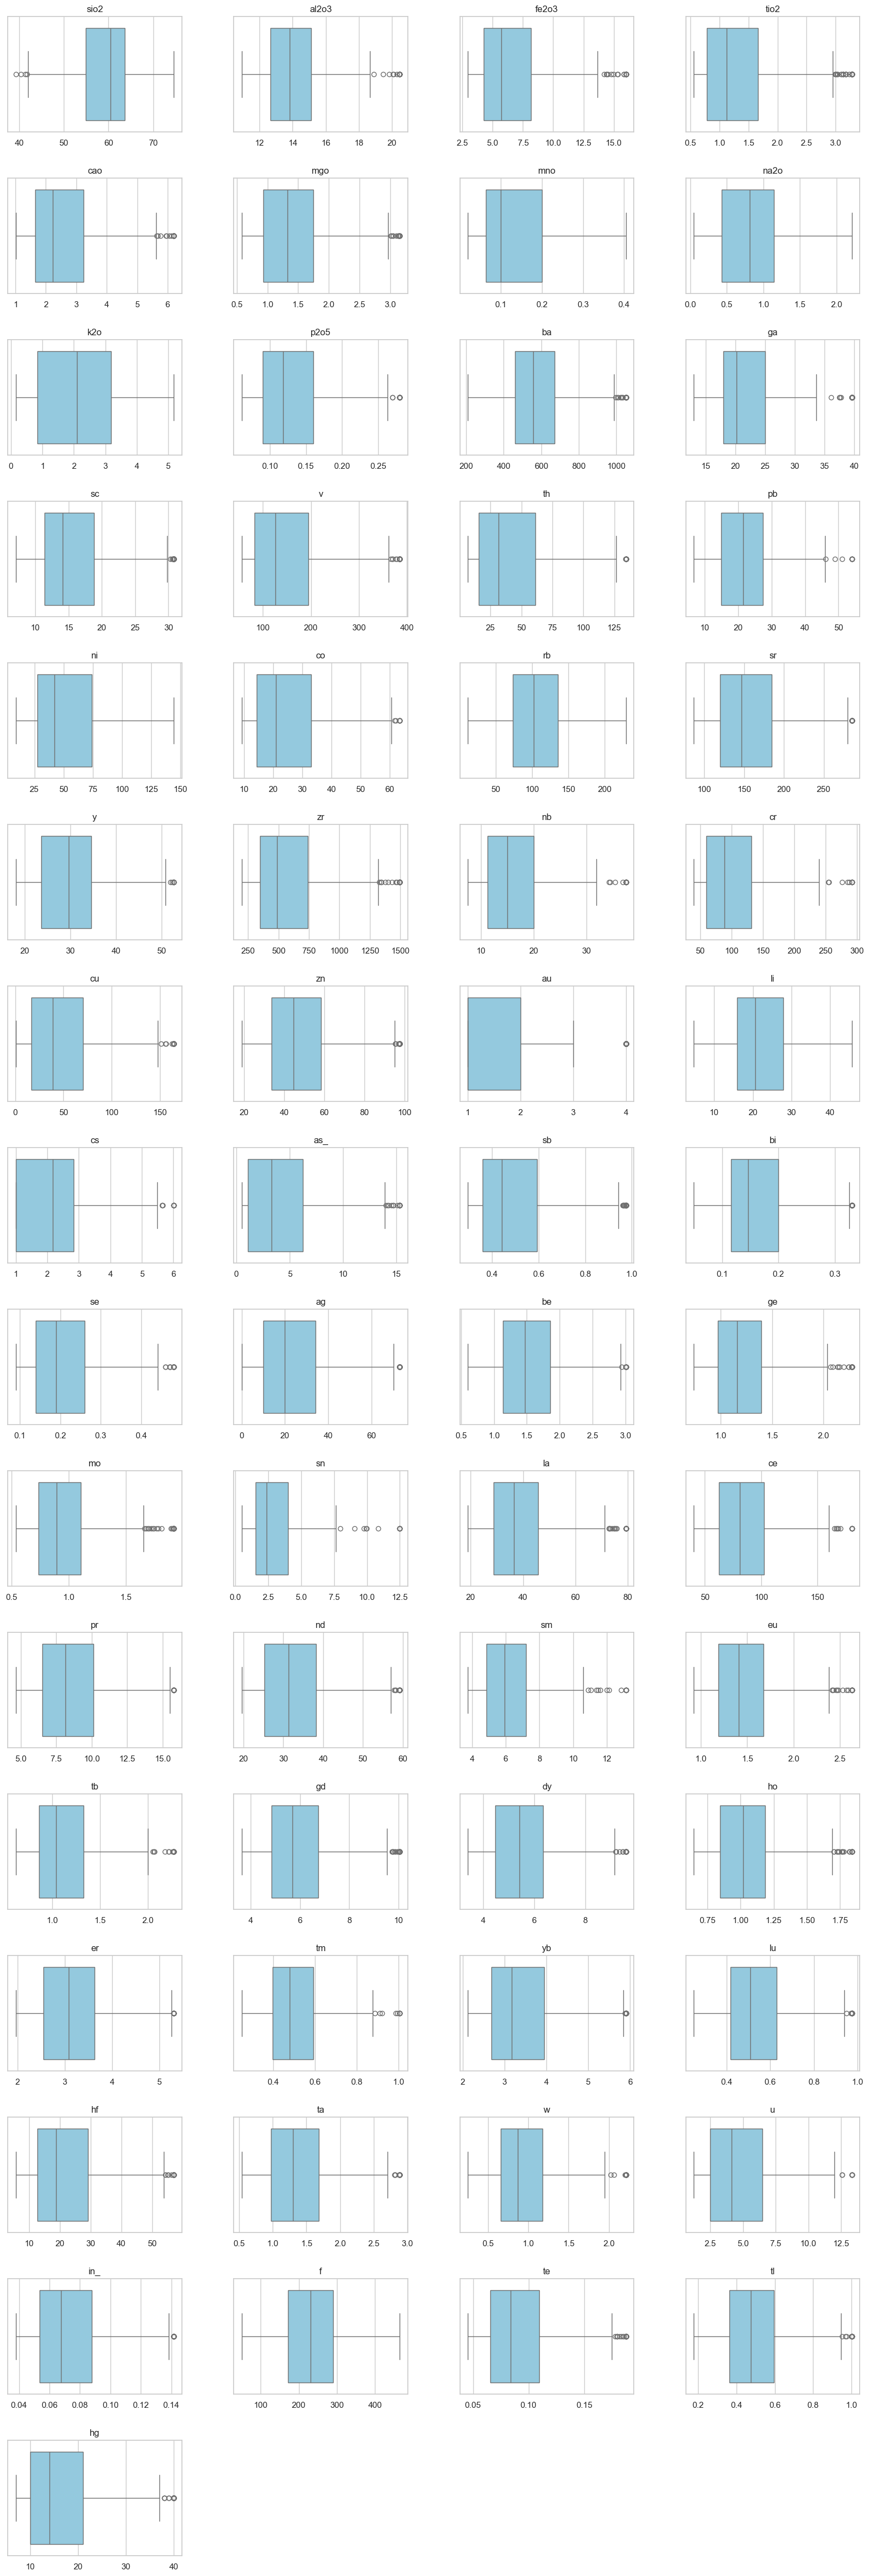

In [97]:
n_elem = len(elem_outl_df.columns)

fig, axes = plt.subplots(nrows=(n_elem+4-1)//4, 
                         ncols=4, 
                         figsize=(20, 4 * (n_elem//4)))

fig.subplots_adjust(hspace=0.4, wspace=0.3)  # Adjust spacing between plots

# Plot each element in its subplot
for i, (elem, ax) in enumerate(zip(elem_outl_df.columns, axes.flatten())):
    sns.boxplot(x=elem_outl_df[elem_outl_df.columns][elem], 
                ax=ax, 
                color="skyblue")
    ax.set_title(elem)
    ax.set_xlabel('')  # Clear the x-labels if they clutter the plot

#If there are any leftover axes, turn them off
for j in range(i + 1, ((n_elem+4-1)//4) * 4):
    axes.flatten()[j].set_visible(False)

plt.show()

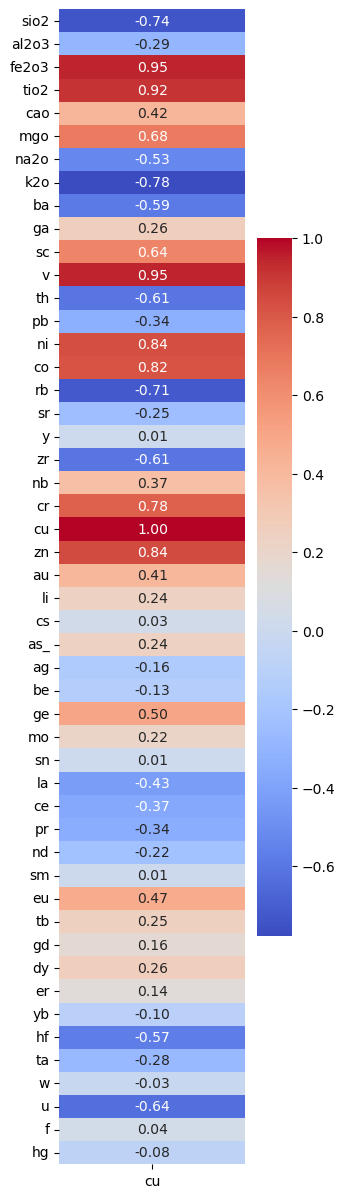

In [21]:
corr_df = elem_outl_df.corr()
target_corr = corr_df[['cu']]

plt.figure(figsize=(3,15))
sns.heatmap(target_corr, 
            annot=True, 
            fmt=".2f", 
            cmap='coolwarm')
plt.show()

In [20]:
elem_outl_df = elem_outl_df[['sio2', 'fe2o3', 'tio2', 'v', 'zn', 'ni', 'co', 'cu', 'mgo', 'k2o', 'sc', 'th', 'rb', 'zr', 'cr', 'u']]

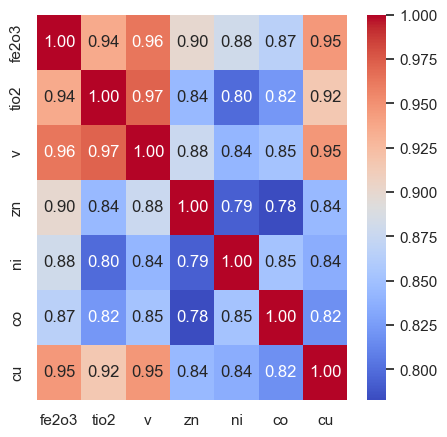

In [74]:
plt.figure(figsize=(5,5))
sns.heatmap(new_df.corr(), 
            annot=True, 
            fmt=".2f", 
            cmap='coolwarm')
plt.show()

In [75]:
elem_outl_df.drop(['fe2o3', 'tio2', 'v'], axis=1, inplace=True)

# Feature Selection

## Split into train, validation and test data

- Save the processed elements data into file

In [43]:
elem_outl_df.to_csv(data_path+'/Kodangal dataset/proc_elem_Kodangal_gcM.csv', index=False)

- Load the saved processed elements data from file

In [44]:
elem_df = pd.read_csv(data_path + '/Kodangal dataset/proc_elem_Kodangal_gcM.csv')

In [45]:
train_df = elem_df.copy()
target = elem_df['cu']
train_df.drop(['cu'], axis=1, inplace=True)

In [46]:
X_train, X_test, y_train, y_test = train_test_split(train_df, 
                                                    target, 
                                                    test_size=0.1, 
                                                    random_state=42,
                                                    shuffle=True)

In [47]:
X_train, X_val, y_train, y_val = train_test_split(X_train, 
                                                  y_train, 
                                                  test_size=0.1, 
                                                  random_state=42, 
                                                  shuffle=True)

## Normalize

In [48]:
sc = StandardScaler()

norm_data = sc.fit_transform(X_train)

X_train_norm = pd.DataFrame(norm_data, 
                            index=X_train.index, 
                            columns=X_train.columns)

## Estimator: Random Forest

In [49]:
rf = RandomForestRegressor(max_depth= 30, max_features='log2', min_samples_leaf= 1, min_samples_split= 5, n_estimators= 100, n_jobs=-1)
rfecv_rf = rfecv(rf, X_train_norm, y_train, 1, 5)

In [50]:
print('Optimal number of features: {}'.format(rfecv_rf.n_features_))

Optimal number of features: 21


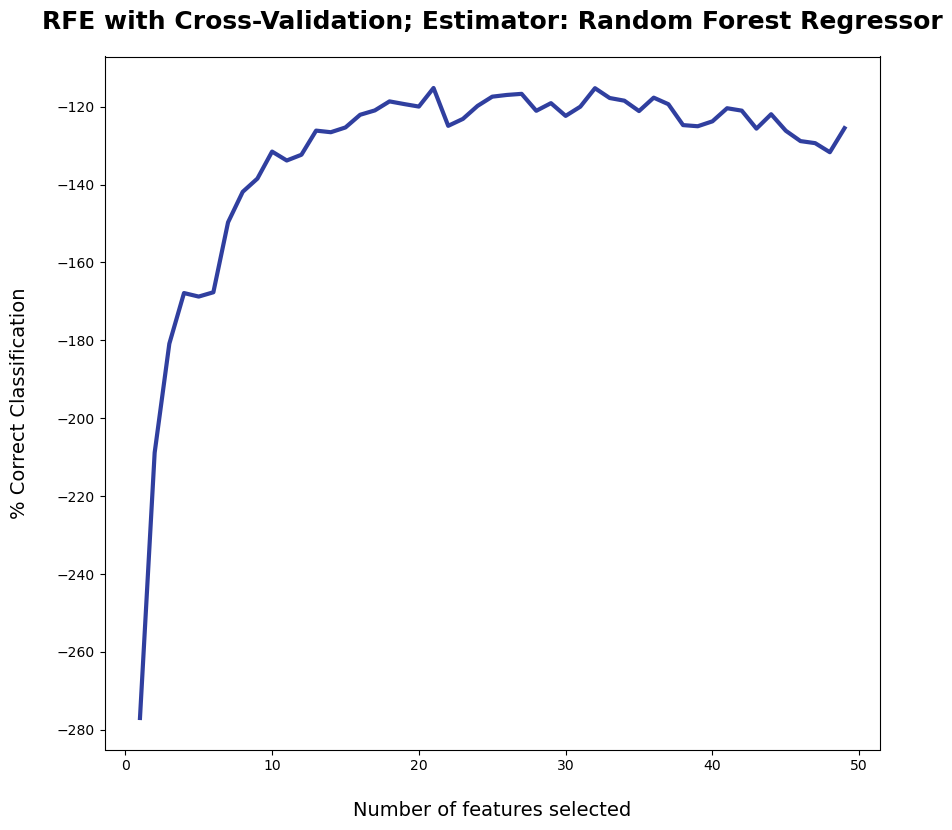

In [51]:
plot_pcc(rfecv_rf, 'RFE with Cross-Validation; Estimator: Random Forest Regressor')

In [65]:
X_rf = X_train_norm.drop(X_train_norm.columns[np.where(rfecv_rf.support_ == False)[0]], axis=1)

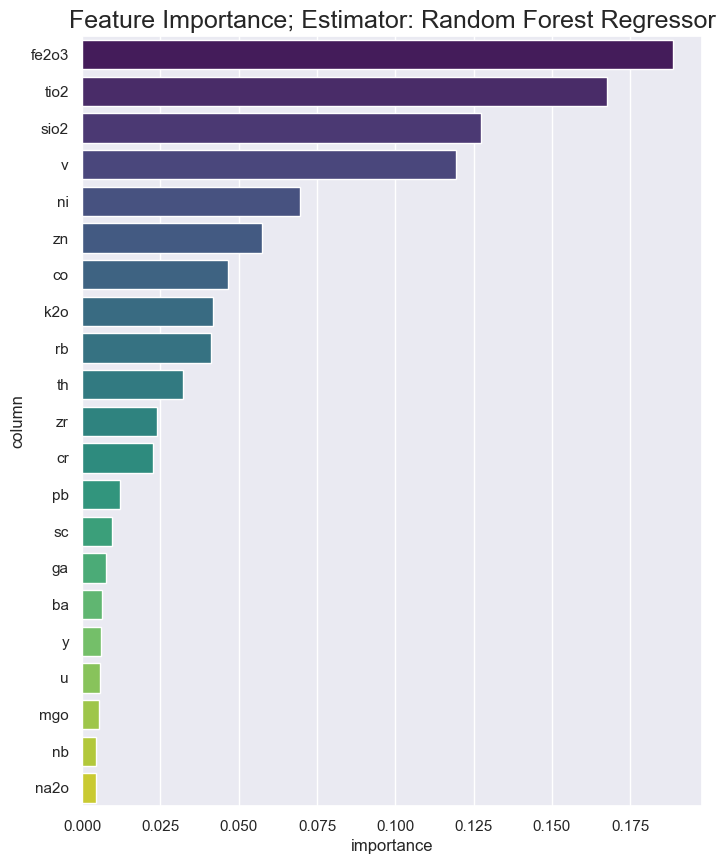

In [53]:
feature_importance(rfecv_rf, X_rf, 'Feature Importance; Estimator: Random Forest Regressor')

In [59]:
# X_rf = X_rf[['sio2', 'zn', 'co', 'k2o', 'rb', 'mno', 'ni']]
X_rf = X_rf[['fe2o3', 'k2o', 'v', 'zn', 'tio2', 'sio2', 'co', 'ni', 'rb', 'cr', 'th', 'zr']]

## Estimator: Gradient Boosting

In [115]:
gbr = GradientBoostingRegressor()
rfecv_bgr = rfecv(gbr, X_train_norm, y_train, 1, 5)

In [116]:
print('Optimal number of features: {}'.format(rfecv_bgr.n_features_))

Optimal number of features: 12


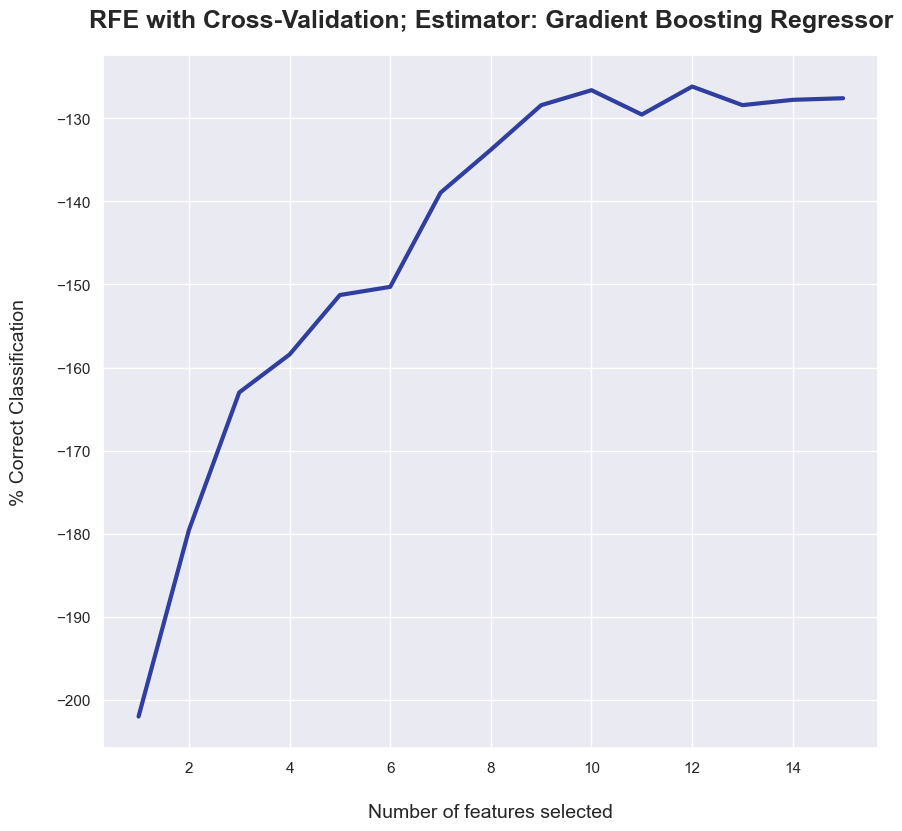

In [117]:
plot_pcc(rfecv_bgr, 'RFE with Cross-Validation; Estimator: Gradient Boosting Regressor')

In [118]:
X_gbr = X_train_norm.drop(X_train_norm.columns[np.where(rfecv_bgr.support_ == False)[0]], axis=1)

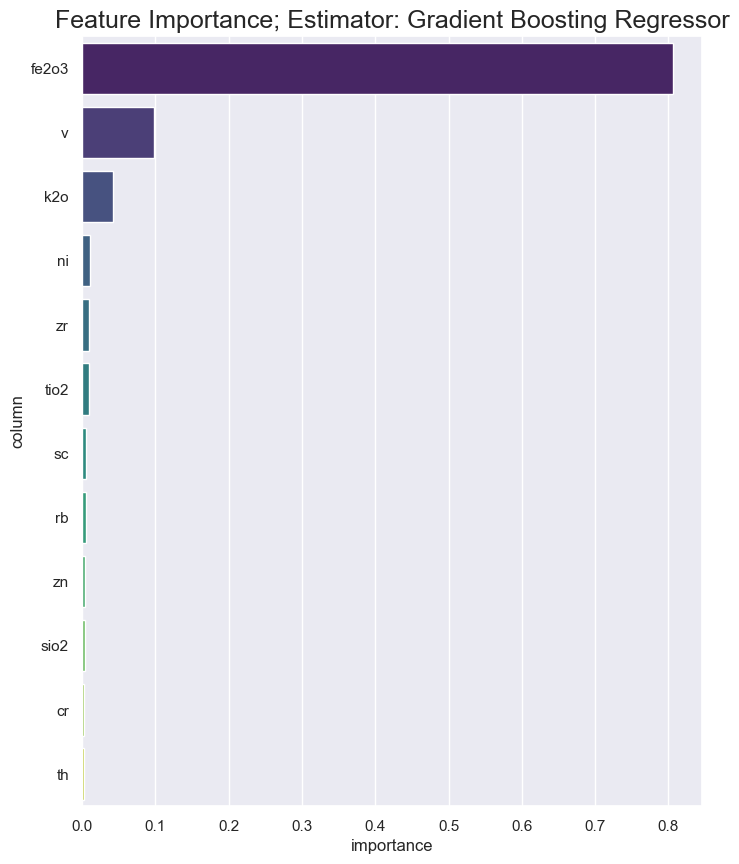

In [119]:
feature_importance(rfecv_bgr, X_gbr, 'Feature Importance; Estimator: Gradient Boosting Regressor')

In [101]:
X_gbr = X_gbr[['v', 'fe2o3', 'rb', 'k2o', 'cr', 'zr']]

# Model Training

## Random Forest

- Estimator: Random Forest

In [66]:
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of trees in the forest
    'max_features': ['auto', 'sqrt', 'log2'],   # Number of features to consider at every split
    'max_depth': [10, 20, 30],    # Maximum number of levels in each tree
    'min_samples_split': [2, 5, 10],            # Minimum number of samples required to split a node
    'min_samples_leaf': [1, 2, 4]              # Minimum number of samples required at each leaf node
}

rf = RandomForestRegressor()

grid_search_rfr_rf = GridSearchCV(rf, 
                                  param_grid, 
                                  cv=5, 
                                  scoring='neg_mean_squared_error', 
                                  verbose=5, 
                                  n_jobs=-1)

grid_search_rfr_rf.fit(X_rf, y_train)

# Get the best hyperparameters
best_params = grid_search_rfr_rf.best_params_
print("Best Hyperparameters:", best_params)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Best Hyperparameters: {'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


### Run the models on validation data

In [67]:
y_pred_val = pred_val(X_val, list(X_rf.columns), sc, grid_search_rfr_rf)

In [68]:
eval_model(y_val, y_pred_val, 'Validation set')

Validation set
Mean Squared Error: 216.26
Root Mean Squared Error: 14.71
Mean Absolute Error: 9.03
R-squared Error: 0.93


### Run the model on test data

In [69]:
y_pred = pred_val(X_test, list(X_rf.columns), sc, grid_search_rfr_rf)

In [70]:
eval_model(y_test, y_pred, 'Test set')

Test set
Mean Squared Error: 140.15
Root Mean Squared Error: 11.84
Mean Absolute Error: 8.41
R-squared Error: 0.94


### Learning Curve

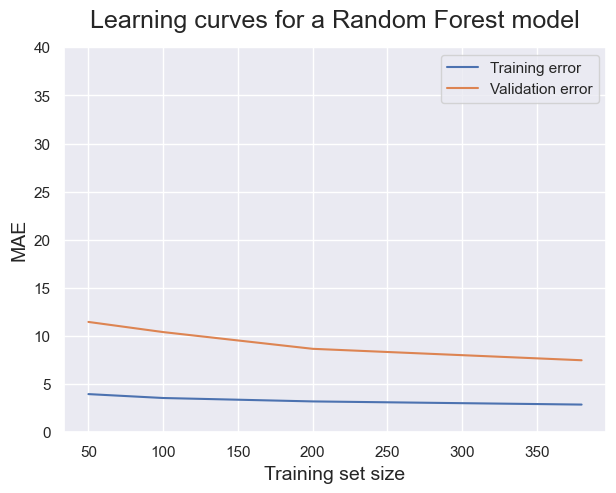

In [83]:
plot_learing_curve(RandomForestRegressor(max_depth=30, 
                                         max_features='sqrt', 
                                         min_samples_leaf=1, 
                                         min_samples_split=2, 
                                         n_estimators=100), 
                   X_rf, y_train, 5, 'Random Forest')

- Estimator: Gradient Boosting

In [120]:
param_grid = {
    'n_estimators': [50, 100, 150, 200, 250],
    'max_depth': [10, 20, 30],
    'min_samples_split': [5, 10, 15],
    'max_features': ['auto', 'sqrt', 'log2']
}

rf = RandomForestRegressor()

grid_search_rfr_gb = GridSearchCV(rf, 
                                  param_grid, 
                                  cv=5, 
                                  scoring='neg_mean_squared_error', 
                                  verbose=5, 
                                  n_jobs=-1)

grid_search_rfr_gb.fit(X_gbr, y_train)

# Get the best hyperparameters
best_params = grid_search_rfr_gb.best_params_
print("Best Hyperparameters:", best_params)

Fitting 5 folds for each of 135 candidates, totalling 675 fits
Best Hyperparameters: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_split': 5, 'n_estimators': 250}


### Run the models on validation data

In [121]:
y_pred_val = pred_val(X_val, list(X_gbr.columns), sc, grid_search_rfr_gb)

In [122]:
eval_model(y_val, y_pred_val, 'Validation set')

Validation set
Mean Squared Error: 228.32
Root Mean Squared Error: 15.11
Mean Absolute Error: 9.42
R-squared Error: 0.92


### Run the model on test data

In [123]:
y_pred = pred_val(X_test, list(X_gbr.columns), sc, grid_search_rfr_gb)

In [124]:
eval_model(y_test, y_pred, 'Test set')

Test set
Mean Squared Error: 177.62
Root Mean Squared Error: 13.33
Mean Absolute Error: 9.76
R-squared Error: 0.92


## XGBoost

- Estimator: Random Forest

In [84]:
param_grid = {
    'n_estimators': [200, 300],    
    'learning_rate': [0.01, 0.1],  
    'max_depth': [3, 5, 7],          
    'colsample_bytree': [0.5, 0.7, 1.0], 
    #'subsample': [0.5, 0.7, 1.0],        
    'gamma': [0.1, 0.2],             
    'reg_alpha': [0.5, 1],       
    'reg_lambda': [0.5, 1],           
    'objective': ['reg:squarederror']
}

xgb = xgboost.XGBRegressor()

grid_search_xgb_rf = GridSearchCV(xgb, 
                                  param_grid, 
                                  cv=5, 
                                  scoring='neg_mean_squared_error', 
                                  verbose=5, 
                                  n_jobs=-1)

grid_search_xgb_rf.fit(X_rf, y_train)

# Get the best hyperparameters
best_params = grid_search_xgb_rf.best_params_
print("Best Hyperparameters:", best_params)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits
Best Hyperparameters: {'colsample_bytree': 0.5, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'objective': 'reg:squarederror', 'reg_alpha': 1, 'reg_lambda': 1}


### Run the model on validation data

In [85]:
y_pred_val = pred_val(X_val, list(X_rf.columns), sc, grid_search_xgb_rf)

In [86]:
eval_model(y_val, y_pred_val, 'Validation set')

Validation set
Mean Squared Error: 175.21
Root Mean Squared Error: 13.24
Mean Absolute Error: 8.02
R-squared Error: 0.94


### Run the model on test data

In [87]:
y_pred = pred_val(X_test, list(X_rf.columns), sc, grid_search_xgb_rf)

In [88]:
eval_model(y_test, y_pred, 'Test set')

Test set
Mean Squared Error: 129.41
Root Mean Squared Error: 11.38
Mean Absolute Error: 7.63
R-squared Error: 0.94


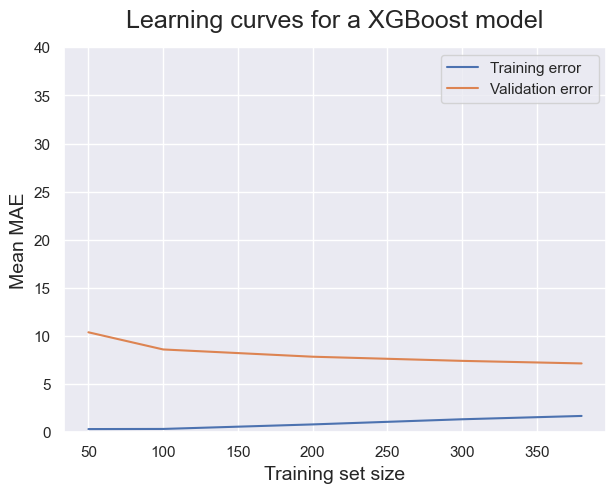

In [93]:
plot_learing_curve(xgboost.XGBRegressor(colsample_bytree=0.5, 
                                        gamma=0.1, 
                                        learning_rate=0.1, 
                                        max_depth=3, 
                                        n_estimators=200, 
                                        objective='reg:squarederror', 
                                        reg_alpha=1, 
                                        reg_lambda=1), 
                   X_rf, y_train, 5, 'XGBoost')

- Estimator: Gradient Boosting

In [125]:
param_grid = {
    'n_estimators': [100, 200, 300],    
    'learning_rate': [0.01, 0.1],  
    'max_depth': [3, 5, 7],          
    'colsample_bytree': [0.5, 0.7, 1.0], 
    #'subsample': [0.5, 0.7, 1.0],        
    'gamma': [0.1, 0.2],             
    'reg_alpha': [0, 0.1, 0.5, 1],       
    'reg_lambda': [0.5, 1, 1.5, 2],           
    'objective': ['reg:squarederror']
}

xgb = xgboost.XGBRegressor()

grid_search_xgb_gb = GridSearchCV(xgb, 
                                  param_grid, 
                                  cv=5, 
                                  scoring='neg_mean_squared_error', 
                                  verbose=5, 
                                  n_jobs=-1)

grid_search_xgb_gb.fit(X_gbr, y_train)

# Get the best hyperparameters
best_params = grid_search_xgb_gb.best_params_
print("Best Hyperparameters:", best_params)

Fitting 5 folds for each of 1728 candidates, totalling 8640 fits
Best Hyperparameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'objective': 'reg:squarederror', 'reg_alpha': 0, 'reg_lambda': 1.5}


### Run the model on validation data

In [126]:
y_pred_val = pred_val(X_val, list(X_gbr.columns), sc, grid_search_xgb_gb)

In [127]:
eval_model(y_val, y_pred_val, 'Validation set')

Validation set
Mean Squared Error: 224.69
Root Mean Squared Error: 14.99
Mean Absolute Error: 9.33
R-squared Error: 0.92


### Run the model on test data

In [128]:
y_pred = pred_val(X_test, list(X_gbr.columns), sc, grid_search_xgb_gb)

In [129]:
eval_model(y_test, y_pred, 'Test set')

Test set
Mean Squared Error: 172.35
Root Mean Squared Error: 13.13
Mean Absolute Error: 9.27
R-squared Error: 0.92


# Saving the models

- ML models

In [60]:
model_path = (os.path.join(curr_dir, 'Models/Kodangal/')).replace('\\', '/')

In [62]:
# Random Forest with RF estimator
with open(model_path + 'RFR_RF.pkl', 'wb') as file:
    pkl.dump(grid_search_rfr_rf, file)

# Random Forest with GB estimator
with open(model_path + 'RFR_GB.pkl', 'wb') as file:
    pkl.dump(grid_search_rfr_gb, file)

# XGBoost with RF estimator
with open(model_path + 'XGB_RF.pkl', 'wb') as file:
    pkl.dump(grid_search_xgb_rf, file)

# XGBoost with GB estimator
with open(model_path + 'XGB_GB.pkl', 'wb') as file:
    pkl.dump(grid_search_xgb_rf, file)

- StandardScaler

In [63]:
with open(model_path + 'standard_scaler.pkl', 'wb') as file:
    pkl.dump(sc, file)

# Test the models

In [78]:
y_test

107    1.0
591    0.0
81     1.0
323    4.0
904    4.0
      ... 
506    1.0
319    1.0
260    1.0
958    5.0
722    0.0
Name: au, Length: 118, dtype: float64

In [116]:
new_obsrv = elem_df[elem_df.index == 81].drop('au', axis=1)
new_obsrv

,sio2,al2o3,fe2o3,tio2,cao,mgo,na2o,k2o,ba,ga,...,er,tm,yb,lu,hf,ta,w,u,f,hg
81,60.19,13.11,7.08,1.45,3.29,1.69,0.25,0.77,521.0,18.0,...,3.311743,0.538243,3.366489,0.548267,16.483437,1.273944,1.377158,2.205044,124.0,10.0


In [117]:
y_pred = pred_val(new_obsrv, list(X_gbr.columns), sc, grid_search_rfr_gb)
y_pred

array([1.59629048])

# Classification

## Load Clean Data

In [5]:
str_sed_data = pd.read_csv(data_path + '/Kodangal dataset/clean_Kodangal_gcM.csv')

In [6]:
str_sed_data.head()

,gid,objectid,sampleno,longitude,latitude,toposheet,sio2,al2o3,fe2o3,tio2,...,hf,ta,w,u,in_,f,te,tl,hg,cd
0,274643,276298,56G04/014/SS/18-19,77.25,17.00904,56G04,44.750,9.414,3.312,0.543,...,5.746369,0.862203,0.991997,1.811020,0.052741,322.0,0.101815,0.293517,17.0,50.0
1,274657,276312,56G04/028/SS/18-19,77.25,17.02711,56G04,45.129,9.853,3.748,0.580,...,7.857656,0.958655,0.943758,2.203597,0.048799,336.0,0.072979,0.300787,8.0,50.0
2,274671,276326,56G04/042/SS/18-19,77.25,17.04518,56G04,58.283,12.534,7.768,1.321,...,8.728652,1.428838,1.682294,2.711943,0.126064,205.0,0.121959,0.481961,12.0,50.0
3,274685,276340,56G04/056/SS/18-19,77.25,17.06325,56G04,61.180,11.670,8.340,1.420,...,9.365000,1.542800,1.803219,2.982200,0.084033,230.0,0.071592,0.427797,10.0,50.0
4,274699,276354,56G04/070/SS/18-19,77.25,17.08132,56G04,60.300,11.470,8.270,1.430,...,10.693400,1.467300,1.451395,3.249200,0.083470,300.0,0.067475,0.447018,6.0,50.0


In [7]:
str_elem = []

for col in list(str_sed_data.columns):
    if col not in ['gid', 
                   'objectid', 
                   'sampleno', 
                   'longitude', 
                   'latitude', 
                   'toposheet']:
        str_elem.append(col)

In [8]:
elem_df = str_sed_data[str_elem]
elem_df.head()

,sio2,al2o3,fe2o3,tio2,cao,mgo,mno,na2o,k2o,p2o5,...,hf,ta,w,u,in_,f,te,tl,hg,cd
0,44.750,9.414,3.312,0.543,14.668,1.573,0.073,0.152,1.258,0.129,...,5.746369,0.862203,0.991997,1.811020,0.052741,322.0,0.101815,0.293517,17.0,50.0
1,45.129,9.853,3.748,0.580,14.042,1.480,0.109,0.167,1.207,0.080,...,7.857656,0.958655,0.943758,2.203597,0.048799,336.0,0.072979,0.300787,8.0,50.0
2,58.283,12.534,7.768,1.321,2.910,1.912,0.192,0.050,0.800,0.061,...,8.728652,1.428838,1.682294,2.711943,0.126064,205.0,0.121959,0.481961,12.0,50.0
3,61.180,11.670,8.340,1.420,2.430,1.710,0.180,0.250,0.660,0.080,...,9.365000,1.542800,1.803219,2.982200,0.084033,230.0,0.071592,0.427797,10.0,50.0
4,60.300,11.470,8.270,1.430,1.990,1.610,0.170,0.230,0.580,0.060,...,10.693400,1.467300,1.451395,3.249200,0.083470,300.0,0.067475,0.447018,6.0,50.0


## Handle outliers

In [10]:
elem_outl_df = handle_outl(elem_df)

## EDA

In [11]:
elem_outl_df.drop('cd', axis=1, inplace=True)

In [13]:
target = elem_outl_df['cu']
target

0       34.60
1       33.81
2       21.12
3       55.50
4       53.20
        ...  
583    164.50
584    101.70
585    126.30
586    164.50
587    164.50
Name: cu, Length: 588, dtype: float64

In [71]:
percentiles = np.linspace(0, 100, 6)
bin_edges = np.percentile(target, percentiles)

bin_labels = [f"{int(percentiles[i])}-{int(percentiles[i+1])}%" for i in range(len(percentiles) - 1)]

bin_indices = np.digitize(target, bin_edges, right=True)

bin_indices = np.clip(bin_indices - 1, 0, len(bin_labels) - 1)

targ_cu = [bin_labels[i] for i in bin_indices]

In [72]:
targ_cat = list(set(targ_cu))
def extract_lower_bound(range_str):
    # Extract the first number using regular expressions
    return int(re.findall(r'\d+', range_str)[0])

targ_cat = sorted(targ_cat, key=extract_lower_bound)
targ_cat

['0-20%', '20-40%', '40-60%', '60-80%', '80-100%']

In [73]:
bins_range = [f'{np.round(bin_edges[i], 2)}-{np.round(bin_edges[i+1], 2)}' for i in range(len(bin_edges)-1)]

ppm_conc_cu = pd.DataFrame({
    'ppm_range' : bins_range,
    '% range' : targ_cat
})
ppm_conc_cu

,ppm_range,% range
0,0.5-13.52,0-20%
1,13.52-31.44,20-40%
2,31.44-49.36,40-60%
3,49.36-96.62,60-80%
4,96.62-164.5,80-100%


In [75]:
elem_outl_df['cu_range'] = targ_cu

In [77]:
elem_outl_df[['cu', 'cu_range']].head()

,cu,cu_range
0,34.60,40-60%
1,33.81,40-60%
2,21.12,20-40%
3,55.50,60-80%
4,53.20,60-80%


## Data Split and Normalise

In [78]:
train_df = elem_outl_df.copy() 
train_df.drop(['cu', 'cu_range'], axis=1, inplace=True)

In [ ]:
target = lbl_enc.fit_transform(target)
target

In [79]:
X_train, X_test, y_train, y_test = train_test_split(train_df, 
                                                    targ_cu, 
                                                    test_size=0.1, 
                                                    random_state=42,
                                                    shuffle=True)

In [80]:
X_train, X_val, y_train, y_val = train_test_split(X_train, 
                                                  y_train, 
                                                  test_size=0.1, 
                                                  random_state=42, 
                                                  shuffle=True)

In [81]:
sc = StandardScaler()

norm_data = sc.fit_transform(X_train)

X_train_norm = pd.DataFrame(norm_data, 
                            index=X_train.index, 
                            columns=X_train.columns)

## Feature Selection

### Estimator: Random Forest